# Horn Antenna Design for Hydrogen Line (1.42 GHz)

This notebook is for designing a horn antenna tuned for the hydrogen line frequency at 1.42 GHz.

## About the Project

The hydrogen line (21 cm line) is at 1420.405751 MHz and is used in radio astronomy to detect neutral hydrogen in space. This project will design a conical horn antenna to receive these signals. The outside will be 3D printed in PETG, while the inside will be covered in copper foil tape with conductive adhesive. PETG has a dielectric constant much different than air, so the conductive element should not be wrapped around the outside.

## Prerequisites

Before running this notebook, ensure you have:
1. OpenEMS installed on your system (see https://docs.openems.de/install.html)
2. Python dependencies installed: `pip install -r requirements.txt`

## References

- OpenEMS Documentation: https://docs.openems.de/
- OpenEMS Python Examples: https://github.com/thliebig/openEMS-Project
- PETG Properties: https://devel.lulzbot.com/filament/Rigid_Ink/PETG%20DATA%20SHEET.pdf
- Copper Tape With Conductive Adhesive: https://www.amazon.com/dp/B07QQHQMYD?th=1

## Imports

In [1]:
# Import required libraries
# Python
import os
import sys

# Math and science
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.special import j1, jvp  # j1 for Bessel function, jvp for derivative
from scipy.optimize import brentq
from matplotlib import figure, legend
from matplotlib.pyplot import plot, title, xlabel, ylabel
from numpy import imag

# CAD Tools
import ezdxf

# OpenEMS and CSXCAD
from CSXCAD import CSXCAD
from openEMS import openEMS
from openEMS.physical_constants import C0, EPS0, MUE0
do_simulation = False # Set to True to enable OpenEMS simulation

# Set up matplotlib for inline plotting
%matplotlib inline

## Computed Design Parameters

Let's compute optimal values for things.

In [2]:
# Constants
hydrogen_line_frequency_hz = 1420.405751768e6  # 1420.405751768 MHz in Hz (precise hydrogen line frequency via Wikipedia)
speed_of_light_meters_per_second = 299792458  # Speed of light in vacuum (m/s) - exact value
hydrogen_line_wavelength_meters = speed_of_light_meters_per_second / hydrogen_line_frequency_hz  # Wavelength in meters

# Target frequency and wavelength
target_center_frequency_hz = hydrogen_line_frequency_hz # Target frequency for the horn antenna.
target_center_frequency_wavelength_meters = speed_of_light_meters_per_second / target_center_frequency_hz # Wavelength of the target frequency in meters.
target_center_frequency_wavelength_mm = target_center_frequency_wavelength_meters * 1e3  # Wavelength in mm

# Compute cutoff frequencies for different modes in circular waveguide
# For TE modes: fc = (p'_mn * c) / (2 * pi * a)
# For TM modes: fc = (p_mn * c) / (2 * pi * a)
# where p'_mn are roots of derivative of Bessel function J_m'(x) = 0
# and p_mn are roots of Bessel function J_m(x) = 0

# Roots for TE modes (J_m'(x) = 0)
root_te11 = brentq(lambda x: jvp(1, x), 1.0, 3.0)  # ≈ 1.841
root_te21 = brentq(lambda x: jvp(2, x), 3.0, 5.0)  # ≈ 3.054
root_te01 = brentq(lambda x: jvp(0, x), 2.0, 4.0)  # ≈ 3.832

# Roots for TM modes (J_m(x) = 0)
# Import j0 for TM01 mode
from scipy.special import j0
root_tm01 = brentq(lambda x: j0(x), 2.0, 3.0)  # ≈ 2.405 (first root of J_0)
# For TM11, we need first root of J_1(x) = 0, which is ≈ 3.832
root_tm11 = brentq(lambda x: j1(x), 3.5, 4.5)  # ≈ 3.832

# target_center_frequency_hz = (root_te11 * speed_of_light_meters_per_second / (pi * waveguide_diameter_meters) + root_te21 * speed_of_light_meters_per_second / (pi * waveguide_diameter_meters)) / 2
# waveguide_diameter_meters = (speed_of_light_meters_per_second * (root_te11 * 1 + root_tm01)) / (2 * np.pi * target_center_frequency_hz)

# waveguide_diameter_meters = 0.25

# Let's find the optimal waveguide diameter that places TE11 cutoff below the target frequency
# but weight the TE11 cutoff more than the tm01 cutoff. This is the correct way to determine waveguide size.
# Margins for te11 and tm01 modes.
te11_margin = 1.3
tm01_margin = 1.25

waveguide_diameter_min = (root_te11 * speed_of_light_meters_per_second) / (np.pi * (target_center_frequency_hz / te11_margin))
waveguide_diameter_max = (root_tm01 * speed_of_light_meters_per_second) / (np.pi * (tm01_margin * target_center_frequency_hz))

waveguide_diameter_meters = (waveguide_diameter_min + waveguide_diameter_max) / 2

te11_cutoff_frequency_hz = (root_te11 * speed_of_light_meters_per_second) / (np.pi * waveguide_diameter_meters)
tm01_cutoff_frequency_hz = (root_tm01 * speed_of_light_meters_per_second) / (np.pi * waveguide_diameter_meters)

if te11_cutoff_frequency_hz > (target_center_frequency_hz * 0.9):
    print(f"Warning: TE11 mode cutoff frequency is too close to target frequency: {te11_cutoff_frequency_hz/1e6:.2f} MHz")
if tm01_cutoff_frequency_hz < (target_center_frequency_hz * 1.1):
    print(f"Warning: TM01 mode cutoff frequency is too close to target frequency: {tm01_cutoff_frequency_hz/1e6:.2f} MHz")

print(f"Selected Waveguide Diameter for TE11 mode at {target_center_frequency_hz/1e6:.2f} MHz: {waveguide_diameter_meters*1e3:.2f} mm")
print(f"TE11 Cutoff Frequency: {te11_cutoff_frequency_hz/1e6:.2f} MHz | Delta: {(target_center_frequency_hz - te11_cutoff_frequency_hz)/1e6:.2f} MHz")
print(f"TM01 Cutoff Frequency: {tm01_cutoff_frequency_hz/1e6:.2f} MHz | Delta: {(tm01_cutoff_frequency_hz - target_center_frequency_hz)/1e6:.2f} MHz")

Selected Waveguide Diameter for TE11 mode at 1420.41 MHz: 145.03 mm
TE11 Cutoff Frequency: 1211.48 MHz | Delta: 208.92 MHz
TM01 Cutoff Frequency: 1582.35 MHz | Delta: 161.95 MHz


## Inputted Design Parameters

Let's define the basic parameters for our **conical horn antenna** design.

Aperture Testing: 

aperture_diameter_meters = 3.0 * target_center_frequency_wavelength_meters
```text
Antenna Gain at 1420.406 MHz:
  Max Directivity: 15.70 dBi
  Radiation Efficiency: 93.23%
  Realized Gain: 15.40 dBi

Beamwidth Analysis:
  3 dB Beamwidth : 24.58°
  Left -3 dB     : -12.19°
  Right -3 dB    : 12.39°
  Main beam      : 0.00°
```

aperture_diameter_meters = 2.5 * target_center_frequency_wavelength_meters:
```text
Antenna Gain at 1420.406 MHz:
  Max Directivity: 15.94 dBi
  Radiation Efficiency: 94.07%
  Realized Gain: 15.67 dBi

Beamwidth Analysis:
  3 dB Beamwidth : 28.06°
  Left -3 dB     : -13.92°
  Right -3 dB    : 14.14°
  Main beam      : 0.00°
```

aperture_diameter_meters = 2.0 * target_center_frequency_wavelength_meters:
```text
Antenna Gain at 1420.406 MHz:
  Max Directivity: 15.20 dBi
  Radiation Efficiency: 96.87%
  Realized Gain: 15.06 dBi

Beamwidth Analysis:
  3 dB Beamwidth : 34.55°
  Left -3 dB     : -17.22°
  Right -3 dB    : 17.32°
  Main beam      : 0.00°
```

In [ ]:
horn_length_meters = 1.3 * target_center_frequency_wavelength_meters            # Axial length of the horn
aperture_diameter_meters = 1.3 * target_center_frequency_wavelength_meters    # Output aperture diameter
fillet_radius_meters = target_center_frequency_wavelength_meters * 20 * 0.15       # Fillet radius Between 0.05λ and 0.15λ is typical
fillet_radius_mm = fillet_radius_meters * 1e3

# Calculate half-angle of the cone
flare_angle = np.arctan((aperture_diameter_meters - waveguide_diameter_meters) / (2 * horn_length_meters)) * 180 / np.pi

# Calculate horn profile line segments
horn_profile_xy_meters = []
final_horn_coordinate_meters = (horn_length_meters, aperture_diameter_meters / 2)

# Calculate horn profile with fillet
fillet_xc_meters = 0.0
fillet_yc_meters = (waveguide_diameter_meters / 2) + fillet_radius_meters
fillet_theta = 0.0
fillet_theta_end = np.deg2rad(flare_angle + 90) 
fillet_dtheta = np.deg2rad(1.0)  # angular resolution

while fillet_theta < fillet_theta_end:
    new_x = fillet_xc_meters + fillet_radius_meters * np.sin(fillet_theta)
    new_y = fillet_yc_meters - fillet_radius_meters * np.cos(fillet_theta)

    if new_x > final_horn_coordinate_meters[0]:
        print(f"Reached final horn coordinate during fillet calculation: ({new_x * 1e3:.4f}, {new_y * 1e3:.4f}) mm")
        flare_angle = np.rad2deg(fillet_theta - fillet_dtheta)
        break

    horn_profile_xy_meters.append((new_x, new_y))
    fillet_theta += fillet_dtheta

horn_profile_xy_meters.append(final_horn_coordinate_meters)

# Convert to mm as our standard unit.
waveguide_diameter_mm = waveguide_diameter_meters * 1e3
aperture_diameter_mm = aperture_diameter_meters * 1e3
horn_length_mm = horn_length_meters * 1e3
horn_profile_xy_mm = np.multiply(horn_profile_xy_meters, 1e3)

print(f"Design frequency: {target_center_frequency_hz/1e9:.6f} GHz ({target_center_frequency_hz/1e6:.6f} MHz)")
print(f"Wavelength (λ): {target_center_frequency_wavelength_meters*1000:.2f} mm")

print(f"\nConical Horn Dimensions:")
print(f"  Waveguide diameter: {waveguide_diameter_mm:.1f} mm ({waveguide_diameter_meters/target_center_frequency_wavelength_meters:.2f}λ)")
print(f"  Aperture diameter: {aperture_diameter_meters*1000:.1f} mm ({aperture_diameter_meters/target_center_frequency_wavelength_meters:.2f}λ)")
print(f"  Length: {horn_length_meters*1000:.1f} mm ({horn_length_meters/target_center_frequency_wavelength_meters:.1f}λ)")
print(f"  Flare angle: {flare_angle:.2f}°")

Reached final horn coordinate during fillet calculation: (277.5693, 136.5957) mm
Design frequency: 1.420406 GHz (1420.405752 MHz)
Wavelength (λ): 211.06 mm

Conical Horn Dimensions:
  Waveguide diameter: 145.0 mm (0.69λ)
  Aperture diameter: 274.4 mm (1.30λ)
  Length: 274.4 mm (1.3λ)
  Flare angle: 26.00°


## Conical Horn Antenna Geometry Visualization

Let's visualize the conical horn antenna geometry before simulation.

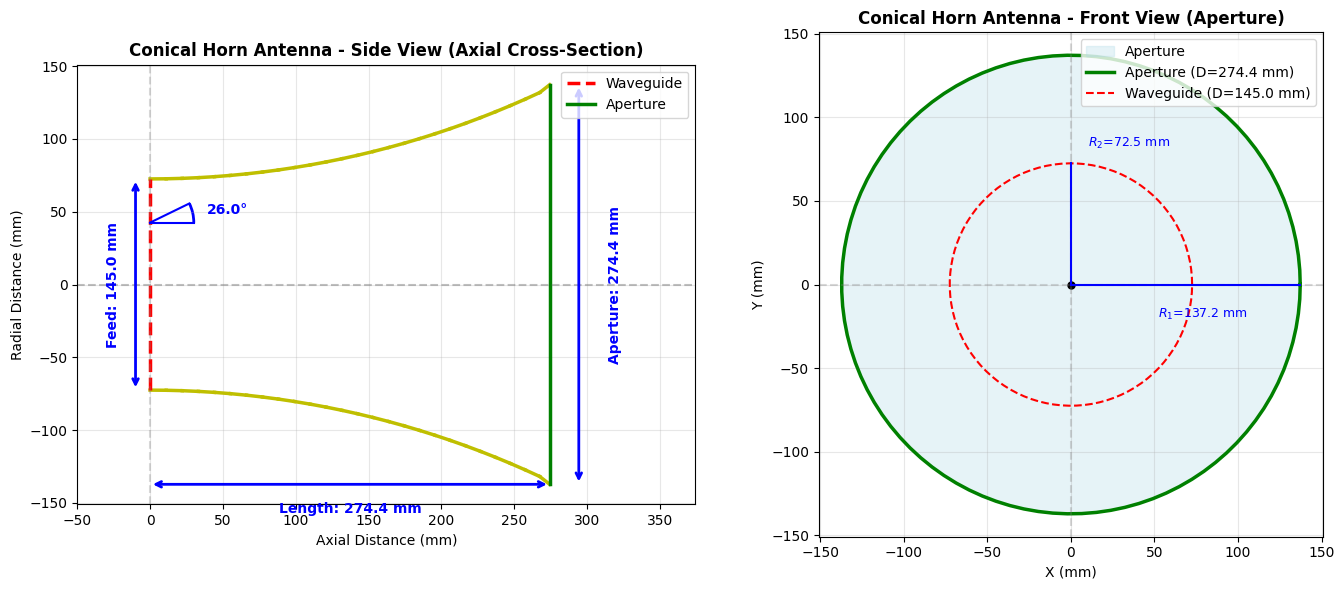


Conical Horn Specifications:
  Waveguide diameter: 145.0 mm
  Aperture diameter: 274.4 mm
  Axial length: 274.4 mm
  Flare angle: 26.00°
  Slant length: 281.9 mm


In [4]:
# Create visualization of the conical horn antenna
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Side view (cross-section through axis)
ax1.set_title('Conical Horn Antenna - Side View (Axial Cross-Section)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Axial Distance (mm)')
ax1.set_ylabel('Radial Distance (mm)')

# Draw conical horn outline
for i in range(len(horn_profile_xy_mm) - 1):
    horn_x = horn_profile_xy_mm[i][0]
    horn_y = horn_profile_xy_mm[i][1]
    horn_x_next = horn_profile_xy_mm[i + 1][0]
    horn_y_next = horn_profile_xy_mm[i + 1][1]
    ax1.plot([horn_x, horn_x_next], [horn_y, horn_y_next], 'y-', linewidth=2.5)
    ax1.plot([horn_x, horn_x_next], [-horn_y, -horn_y_next], 'y-', linewidth=2.5)

ax1.plot([0, 0], [-waveguide_diameter_mm/2, waveguide_diameter_mm/2], 'r--', linewidth=2.5, label='Waveguide')
ax1.plot([horn_length_mm, horn_length_mm], [-aperture_diameter_mm/2, aperture_diameter_mm/2], 'g-', linewidth=2.5, label='Aperture')

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Add flare angle annotation with arc
arc_radius = 30  # mm, radius of the arc
arc_center_x = 0
arc_center_y = (waveguide_diameter_meters/2 * 1e3) - arc_radius
arc = patches.Arc((arc_center_x, arc_center_y), 2*arc_radius, 2*arc_radius, 
                  angle=0, theta1=0, theta2=flare_angle, 
                  color='blue', linewidth=2)
ax1.add_patch(arc)

# Add small lines at arc ends to indicate angle
line_length = 30
ax1.plot([arc_center_x, arc_center_x + line_length], [arc_center_y, arc_center_y], 'b-', linewidth=1.5)
end_x = arc_center_x + arc_radius * np.cos(np.radians(flare_angle))
end_y = arc_center_y + arc_radius * np.sin(np.radians(flare_angle))
ax1.plot([end_x - line_length*np.cos(np.radians(flare_angle)), end_x], 
         [end_y - line_length*np.sin(np.radians(flare_angle)), end_y], 
         'b-', linewidth=1.5)

# Add angle label
label_radius = arc_radius + 10
label_x = arc_center_x + label_radius * np.cos(np.radians(flare_angle/2))
label_y = arc_center_y + label_radius * np.sin(np.radians(flare_angle/2))
ax1.text(label_x, label_y, f'{flare_angle:.1f}°', color='blue', fontsize=10, 
         fontweight='bold', ha='left', va='center')

# Add horn length annotation
ax1.annotate('', xy=(0, -aperture_diameter_meters/2*1e3), 
             xytext=(horn_length_meters*1e3, -aperture_diameter_meters/2*1e3),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
ax1.text(horn_length_meters*1e3/2, -aperture_diameter_meters/2*1e3 - 20, 
         f'Length: {horn_length_meters*1e3:.1f} mm', color='blue', fontsize=10, 
         fontweight='bold', ha='center')

# Add aperture height annotation
ax1.annotate('', xy=(horn_length_meters*1e3 + 20, -aperture_diameter_meters/2*1e3), 
             xytext=(horn_length_meters*1e3 + 20, aperture_diameter_meters/2*1e3),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
ax1.text(horn_length_meters*1e3 + 40, 0, 
         f'Aperture: {aperture_diameter_meters*1e3:.1f} mm', color='blue', fontsize=10, 
         fontweight='bold', rotation=90, va='center')

# Add feed height annotation
ax1.annotate('', xy=(-10, -waveguide_diameter_meters/2*1e3), 
             xytext=(-10, waveguide_diameter_meters/2*1e3),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
ax1.text(-30, 0, 
         f'Feed: {waveguide_diameter_meters*1e3:.1f} mm', color='blue', fontsize=10, 
         fontweight='bold', rotation=90, va='center')

ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')
ax1.set_xlim(-50, horn_length_meters*1e3 + 100)
ax1.legend(loc='upper right')

# Front view (aperture view)
ax2.set_title('Conical Horn Antenna - Front View (Aperture)', fontsize=12, fontweight='bold')
ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')

# Draw circular aperture
fillet_theta = np.linspace(0, 2*np.pi, 100)
aperture_x = (aperture_diameter_meters/2) * np.cos(fillet_theta) * 1e3
aperture_y = (aperture_diameter_meters/2) * np.sin(fillet_theta) * 1e3
waveguide_x = (waveguide_diameter_meters/2) * np.cos(fillet_theta) * 1e3
waveguide_y = (waveguide_diameter_meters/2) * np.sin(fillet_theta) * 1e3

ax2.fill(aperture_x, aperture_y, color='lightblue', alpha=0.3, label='Aperture')
ax2.plot(aperture_x, aperture_y, 'g-', linewidth=2.5, label=f'Aperture (D={aperture_diameter_meters*1000:.1f} mm)')
ax2.plot(waveguide_x, waveguide_y, 'r--', linewidth=1.5, label=f'Waveguide (D={waveguide_diameter_meters*1000:.1f} mm)')

# Add center point and axis indicators
ax2.plot(0, 0, 'ko', markersize=5)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Add aperture radius annotation
ax2.plot([0, aperture_diameter_meters/2*1e3], [0, 0], 'b-', linewidth=1.5)
ax2.text(aperture_diameter_meters/4*1e3 + 10, -20, f'$R_1$={aperture_diameter_meters/2*1000:.1f} mm', 
         color='blue', fontsize=9, ha='center')

# Add waveguide radius annotation
ax2.plot([0, 0], [0, waveguide_diameter_meters/2*1e3], 'b-', linewidth=1.5)
ax2.text(10, waveguide_diameter_meters/2*1e3 + 10, f'$R_2$={waveguide_diameter_meters/2*1000:.1f} mm', 
         color='blue', fontsize=9, ha='left')

ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nConical Horn Specifications:")
print(f"  Waveguide diameter: {waveguide_diameter_meters*1000:.1f} mm")
print(f"  Aperture diameter: {aperture_diameter_meters*1000:.1f} mm")
print(f"  Axial length: {horn_length_meters*1000:.1f} mm")
print(f"  Flare angle: {flare_angle:.2f}°")
print(f"  Slant length: {np.sqrt(horn_length_meters**2 + ((aperture_diameter_meters-waveguide_diameter_meters)/2)**2)*1000:.1f} mm")


## Feed and Receiving Element Design

For the conical horn antenna, we need to design:
1. **Circular waveguide feed section** - provides the TE11 mode propagation
2. **Coaxial probe feed** - transitions from 50Ω coax to the circular waveguide
3. **Probe dimensions and positioning** - for optimal impedance matching

In [5]:
# Circular Waveguide Feed Parameters
# For TE11 mode (dominant mode in circular waveguide)

# TE11 cutoff frequency: fc = 1.841 * c / (π * D)
# where 1.841 is the first root of J1'(x) = 0

# We want f0 > fc, so the waveguide operates above cutoff
# Typically operate at f/fc = 1.2 to 1.5 for good single-mode operation

root_te11 = brentq(lambda x: jvp(1, x), 1.0, 3.0)
cutoff_frequency = root_te11 * speed_of_light_meters_per_second / (np.pi * waveguide_diameter_meters)
guided_wavelength = target_center_frequency_wavelength_meters / np.sqrt(1 - (cutoff_frequency/target_center_frequency_hz)**2)

print("Circular Waveguide Feed (TE11 Mode):")
print("="*60)
print(f"Waveguide diameter: {waveguide_diameter_meters*1000:.2f} mm ({waveguide_diameter_meters*1e3/25.4:.3f} inches)")
print(f"Cutoff frequency (fc): {cutoff_frequency/1e9:.3f} GHz ({cutoff_frequency/1e6:.1f} MHz)")
print(f"Operating frequency: {target_center_frequency_hz/1e9:.3f} GHz ({target_center_frequency_hz/1e6:.1f} MHz)")
print(f"Center frequency/fc ratio: {target_center_frequency_hz/cutoff_frequency:.2f}")
print(f"Free-space wavelength (λ0): {target_center_frequency_wavelength_meters*1000:.2f} mm")
print(f"Guide wavelength (λg): {guided_wavelength*1000:.2f} mm")
print(f"λg/λ0 ratio: {guided_wavelength/target_center_frequency_wavelength_meters:.2f}")

# Check for single-mode operation
if 1.2 <= target_center_frequency_hz/cutoff_frequency <= 1.8:
    print(f"\n✓ Good single-mode operation (1.2 < target_center_frequency_hz/fc < 1.8)")
else:
    print(f"\n⚠ Warning: target_center_frequency_hz/fc = {target_center_frequency_hz/cutoff_frequency:.2f} may not be optimal")
    if target_center_frequency_hz/cutoff_frequency < 1.2:
        print("  Consider reducing waveguide diameter")
    else:
        print("  Risk of higher-order modes")

# Waveguide length calculations
# Probe to throat section should not be resonant.
# Probe to throat >= 0.25 λg
# Backshort to probe distance = λg / 4 +- 20% for tuning.
# So most full waveguide lengths are between 0.6 - 0.75 #λg
probe_to_throat_wavelength_lg = 0.4 #λg
backshort_to_probe_wavelength_lg = 0.25 #λg
waveguide_length_meters = guided_wavelength * (probe_to_throat_wavelength_lg + backshort_to_probe_wavelength_lg)
waveguide_length_mm = waveguide_length_meters * 1e3
probe_backshort_distance_meters = guided_wavelength * backshort_to_probe_wavelength_lg
probe_backshort_distance_mm = probe_backshort_distance_meters * 1e3

print(f"\nRecommended feed length: {waveguide_length_meters*1000:.1f} mm ({waveguide_length_meters/target_center_frequency_wavelength_meters:.2f}λ0, {guided_wavelength}λg)")

Circular Waveguide Feed (TE11 Mode):
Waveguide diameter: 145.03 mm (5.710 inches)
Cutoff frequency (fc): 1.211 GHz (1211.5 MHz)
Operating frequency: 1.420 GHz (1420.4 MHz)
Center frequency/fc ratio: 1.17
Free-space wavelength (λ0): 211.06 mm
Guide wavelength (λg): 404.29 mm
λg/λ0 ratio: 1.92

⚠ Warning: target_center_frequency_hz/fc = 1.17 may not be optimal
  Consider reducing waveguide diameter

Recommended feed length: 262.8 mm (1.25λ0, 0.4042910247931648λg)


In [6]:
# Coaxial Probe Feed Design
# The probe couples electromagnetic energy from coax cable into the circular waveguide

# Standard coax impedance
Z0_coax = 50  # ohms (standard for RF systems)

# Waveguide impedance for TE11 mode
# Z_TE11 ≈ 502 * (λ0/λg) for circular waveguide
Z_waveguide = 502 * (target_center_frequency_wavelength_meters / guided_wavelength)

print("\nCoaxial Probe Feed Design:")
print("="*60)
print(f"Coax impedance (Z0): {Z0_coax} Ω")
print(f"Waveguide impedance (Z_TE11): {Z_waveguide:.1f} Ω")
print(f"Impedance ratio: {Z_waveguide/Z0_coax:.2f}")

# Probe length - critical for impedance matching
# The probe is a quarter-wave monopole antenna - uses FREE SPACE wavelength, not guide wavelength!
probe_length_meters = target_center_frequency_wavelength_meters / 4  # λ0/4 for resonance
# Shorten the probe length slightly to help with matching
probe_length_meters = probe_length_meters # Add 20 mm. I'm just trying to reduce the VSWR and tune it.

# Alternative probe lengths for different coupling
probe_length_short = target_center_frequency_wavelength_meters / 5  # Weaker coupling
probe_length_optimal = target_center_frequency_wavelength_meters / 4  # Optimal coupling (quarter-wave resonance)
probe_length_long = target_center_frequency_wavelength_meters / 3.5  # Stronger coupling

print(f"\nProbe Length Options (based on λ0, NOT λg):")
print(f"  Short coupling (λ0/5): {probe_length_short*1000:.1f} mm")
print(f"  Optimal coupling (λ0/4): {probe_length_optimal*1000:.1f} mm  ← Recommended")
print(f"  Strong coupling (λ0/3.5): {probe_length_long*1000:.1f} mm")

# Probe diameter - typically 1-3 mm for 1.4 GHz
# Should be << wavelength for thin monopole approximation
probe_diameter_min = 1.0e-3  # 1 mm
probe_diameter_typ = 1.5e-3  # 1.5 mm (typical)
probe_diameter_max = 2.5e-3  # 2.5 mm

print(f"\nProbe Diameter Options:")
print(f"  Minimum: {probe_diameter_min*1000:.1f} mm")
print(f"  Typical: {probe_diameter_typ*1000:.1f} mm  ← Recommended")
print(f"  Maximum: {probe_diameter_max*1000:.1f} mm")
print(f"  (Should be << λ0 = {target_center_frequency_wavelength_meters*1000:.1f} mm)")

print(f"\nProbe Position:")
print(f"  Distance from backshort: {probe_backshort_distance_meters*1000:.1f} mm (λg/4)")
print(f"  This positions the probe at the E-field maximum")

# Probe offset from center (for circular waveguide)
# For TE11 mode, maximum E-field is at approximately 0.4*radius from center
probe_offset = 0.4 * (waveguide_diameter_meters / 2)

print(f"  Radial offset from center: {probe_offset*1000:.1f} mm")
print(f"  (Approximately 0.4R for maximum TE11 coupling)")

# SMA connector dimensions (standard panel-mount SMA)
sma_mounting_hole = 6.5e-3  # 6.5 mm mounting hole diameter
sma_pin_diameter = 1.3e-3   # 1.3 mm center pin diameter (slightly larger than 0.51mm for mechanical strength)
sma_flange_diameter = 9.5e-3  # 9.5 mm flange diameter
print(f"\nSMA Connector (50Ω Panel-Mount):")
print(f"  Type: Standard SMA female panel-mount")
print(f"  Mounting hole: {sma_mounting_hole*1000:.1f} mm")
print(f"  Center pin diameter: {sma_pin_diameter*1000:.1f} mm")
print(f"  Impedance: 50 Ω")

# Store probe dimensions for later use
probe_params = {
    'sma_mounting_hole': sma_mounting_hole,
    'sma_pin_dia': sma_pin_diameter
}


print(f"\n✓ Probe parameters calculated and stored")


Coaxial Probe Feed Design:
Coax impedance (Z0): 50 Ω
Waveguide impedance (Z_TE11): 262.1 Ω
Impedance ratio: 5.24

Probe Length Options (based on λ0, NOT λg):
  Short coupling (λ0/5): 42.2 mm
  Optimal coupling (λ0/4): 52.8 mm  ← Recommended
  Strong coupling (λ0/3.5): 60.3 mm

Probe Diameter Options:
  Minimum: 1.0 mm
  Typical: 1.5 mm  ← Recommended
  Maximum: 2.5 mm
  (Should be << λ0 = 211.1 mm)

Probe Position:
  Distance from backshort: 101.1 mm (λg/4)
  This positions the probe at the E-field maximum
  Radial offset from center: 29.0 mm
  (Approximately 0.4R for maximum TE11 coupling)

SMA Connector (50Ω Panel-Mount):
  Type: Standard SMA female panel-mount
  Mounting hole: 6.5 mm
  Center pin diameter: 1.3 mm
  Impedance: 50 Ω

✓ Probe parameters calculated and stored


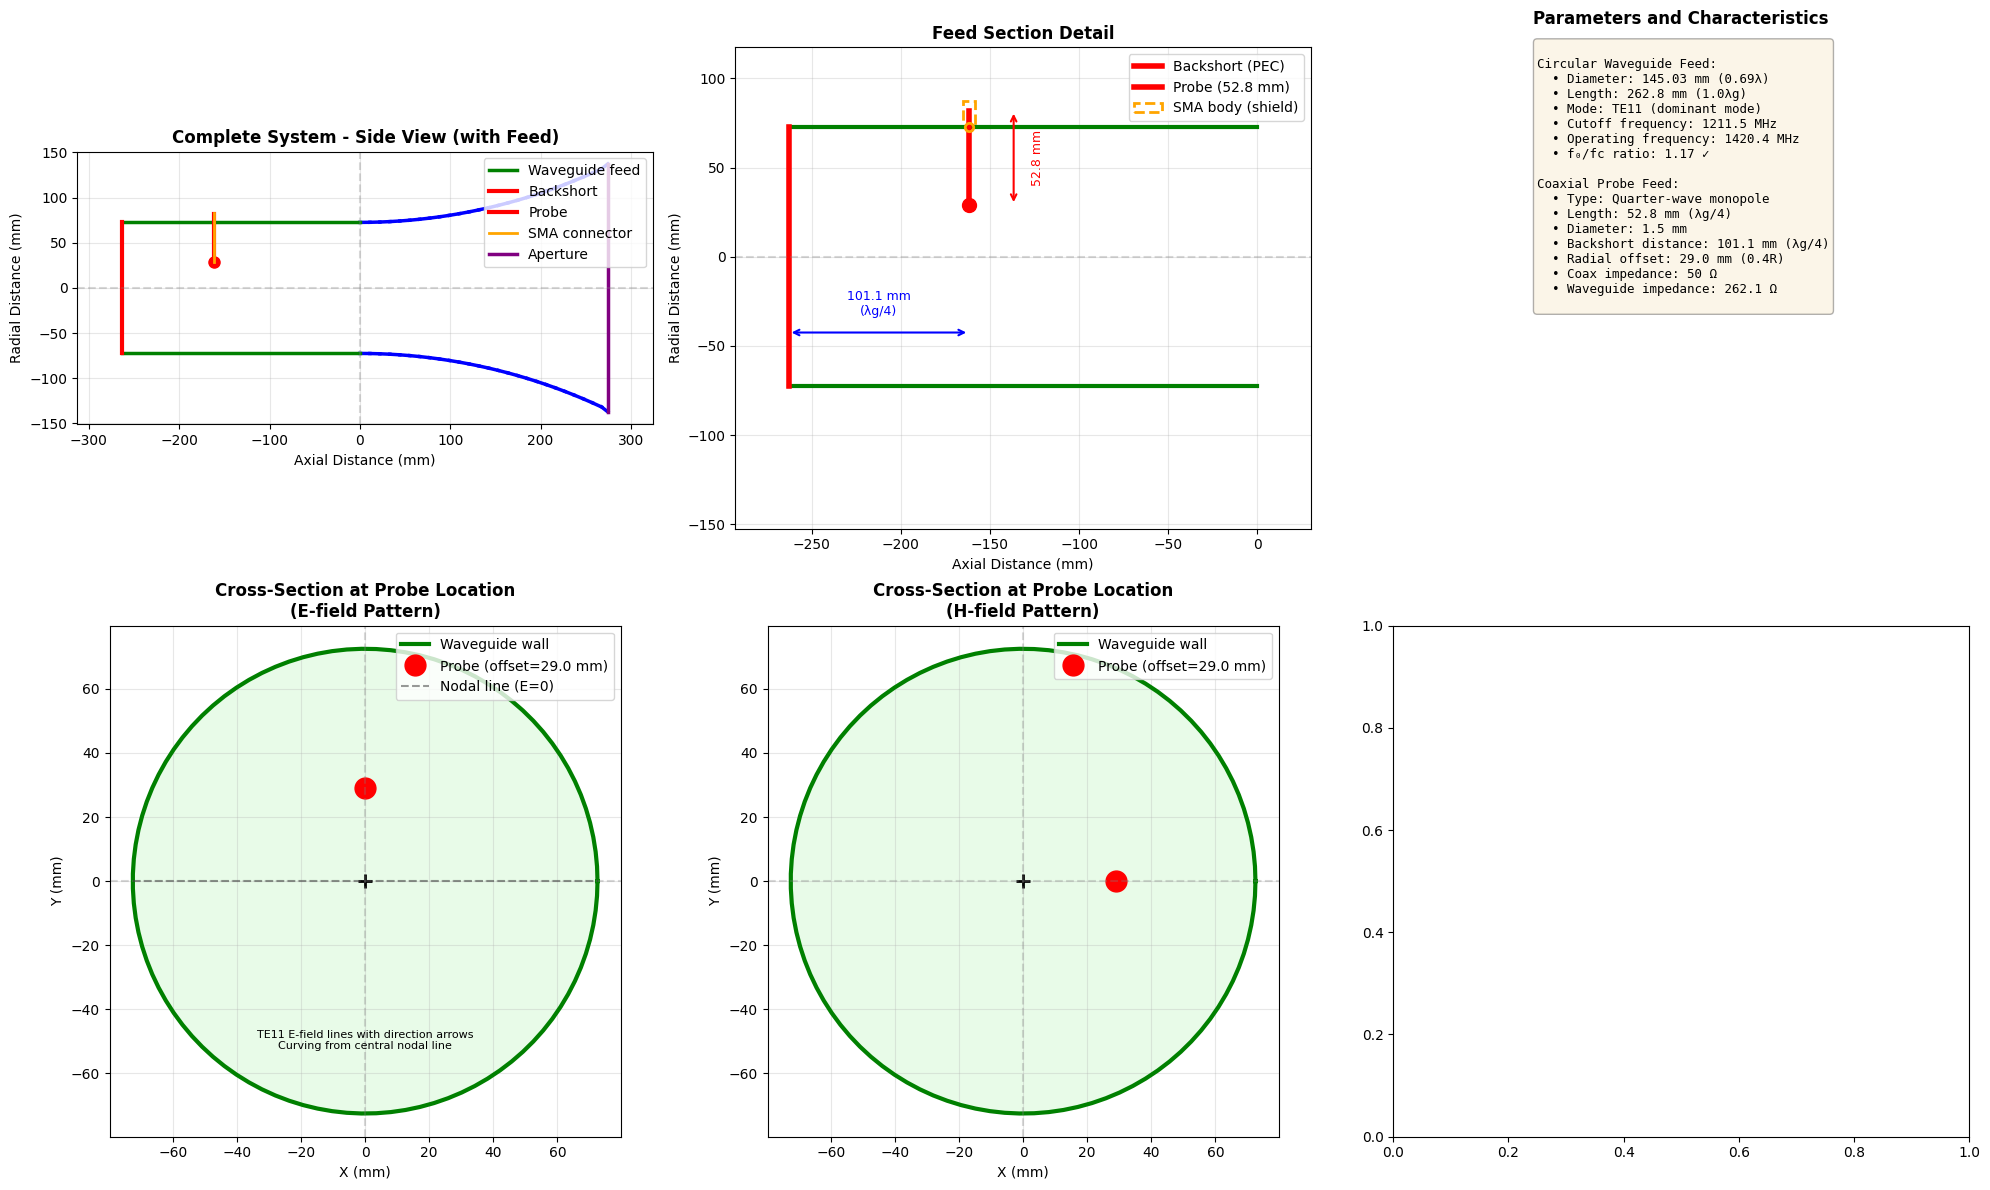

In [7]:
# Visualization of Feed Structure

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Side view - complete system with feed
ax1 = axes[0, 0]
ax1.set_title('Complete System - Side View (with Feed)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Axial Distance (mm)')
ax1.set_ylabel('Radial Distance (mm)')

# Horn outline
#ax1.plot([0, horn_length_meters*1e3], [waveguide_diameter_meters/2 * 1e3, aperture_diameter_meters/2 * 1e3], 
#         'b-', linewidth=2.5, label='Horn wall')
#ax1.plot([0, horn_length_meters*1e3], [-waveguide_diameter_meters/2 * 1e3, -aperture_diameter_meters/2 * 1e3], 
#         'b-', linewidth=2.5)

for i in range(len(horn_profile_xy_mm) - 1):
    horn_x = horn_profile_xy_mm[i][0]
    horn_y = horn_profile_xy_mm[i][1]
    horn_x_next = horn_profile_xy_mm[i + 1][0]
    horn_y_next = horn_profile_xy_mm[i + 1][1]
    ax1.plot([horn_x, horn_x_next], [horn_y, horn_y_next], 'b-', linewidth=2.5)
    ax1.plot([horn_x, horn_x_next], [-horn_y, -horn_y_next], 'b-', linewidth=2.5)

# Waveguide feed section (extends behind horn)
feed_start = -waveguide_length_meters*1e3
ax1.plot([feed_start, 0], [waveguide_diameter_meters/2 * 1e3, waveguide_diameter_meters/2 * 1e3], 
         'g-', linewidth=2.5, label='Waveguide feed')
ax1.plot([feed_start, 0], [-waveguide_diameter_meters/2 * 1e3, -waveguide_diameter_meters/2 * 1e3], 
         'g-', linewidth=2.5)

# Backshort (closed end)
ax1.plot([feed_start, feed_start], 
         [-waveguide_diameter_meters/2 * 1e3, waveguide_diameter_meters/2 * 1e3], 
         'r-', linewidth=3, label='Backshort')

# Probe position
probe_x = feed_start + probe_backshort_distance_meters*1e3
probe_y = probe_offset*1e3
ax1.plot([probe_x, probe_x], [probe_y, probe_y + probe_length_meters*1e3], 
         'r-', linewidth=3, label='Probe')
ax1.plot(probe_x, probe_y, 'ro', markersize=8)

# SMA connector entry (perpendicular to waveguide, entering from outside on the probe side)
ax1.plot([probe_x, probe_x], [waveguide_diameter_meters/2 * 1e3 + 10, probe_y], 
         'orange', linewidth=2, label='SMA connector')

# Aperture
ax1.plot([horn_length_meters*1e3, horn_length_meters*1e3], 
         [-aperture_diameter_meters/2 * 1e3, aperture_diameter_meters/2 * 1e3], 
         'purple', linewidth=2.5, label='Aperture')

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')
ax1.set_xlim(feed_start - 50, horn_length_meters*1e3 + 50)
ax1.set_aspect('equal')

# 2. Detailed feed section
ax2 = axes[0, 1]
ax2.set_title('Feed Section Detail', fontsize=12, fontweight='bold')
ax2.set_xlabel('Axial Distance (mm)')
ax2.set_ylabel('Radial Distance (mm)')

# Waveguide walls
ax2.plot([feed_start, 0], [waveguide_diameter_meters/2 * 1e3, waveguide_diameter_meters/2 * 1e3], 
         'g-', linewidth=3)
ax2.plot([feed_start, 0], [-waveguide_diameter_meters/2 * 1e3, -waveguide_diameter_meters/2 * 1e3], 
         'g-', linewidth=3)

# Backshort
ax2.plot([feed_start, feed_start], 
         [-waveguide_diameter_meters/2 * 1e3, waveguide_diameter_meters/2 * 1e3], 
         'r-', linewidth=4, label='Backshort (PEC)')

# Probe
ax2.plot([probe_x, probe_x], [probe_y, probe_y + probe_length_meters*1e3], 
         'r-', linewidth=4, label=f'Probe ({probe_length_meters*1e3:.1f} mm)')
ax2.plot(probe_x, probe_y, 'ro', markersize=10)

# SMA connector (entering from outside the waveguide on the probe side)
sma_entry_start = waveguide_diameter_meters/2 * 1e3 + 15  # Outside the waveguide
waveguide_wall_pos = waveguide_diameter_meters/2 * 1e3  # Waveguide wall position

# Center pin extends from outside, through wall, to probe tip
#ax2.plot([probe_x, probe_x], [sma_entry_start, probe_y], 
#         'orange', linewidth=3, label='SMA center pin')

# SMA body/shield only exists OUTSIDE the waveguide wall (terminates at wall)
ax2.add_patch(plt.Rectangle((probe_x - sma_mounting_hole/2*1e3, 
                             waveguide_wall_pos), 
                            sma_mounting_hole*1e3, 
                            sma_entry_start - waveguide_wall_pos,
                            fill=False, edgecolor='orange', linewidth=2, 
                            linestyle='--', label='SMA body (shield)'))

# Add a small circle at the wall to show where SMA body terminates (flange mount point)
ax2.plot(probe_x, waveguide_wall_pos, 'o', color='orange', markersize=6, 
         markerfacecolor='none', markeredgewidth=2)

# Annotations
ax2.annotate('', xy=(feed_start, -waveguide_diameter_meters/2*1e3 + 30), 
             xytext=(probe_x, -waveguide_diameter_meters/2*1e3 + 30),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=1.5))
ax2.text((feed_start + probe_x)/2, -waveguide_diameter_meters/2*1e3 + 40, 
         f'{probe_backshort_distance_meters*1e3:.1f} mm\n(λg/4)', ha='center', color='blue', fontsize=9)

ax2.annotate('', xy=(probe_x + 25, probe_y), 
             xytext=(probe_x + 25, probe_y + probe_length_meters*1e3),
             arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
ax2.text(probe_x + 35, probe_y + probe_length_meters*1e3/2, 
         f'{probe_length_meters*1e3:.1f} mm', color='red', fontsize=9, rotation=90, va='center')

ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')
ax2.set_aspect('equal')
# Set explicit axis limits to show full feed section including SMA connector
ax2.set_xlim(feed_start - 30, 30)
ax2.set_ylim(-waveguide_diameter_meters/2*1e3 - 80, sma_entry_start + 30)

# 3. Cross-section at probe location - E-field
ax3 = axes[1, 0]
ax3.set_title('Cross-Section at Probe Location\n(E-field Pattern)', fontsize=12, fontweight='bold')
ax3.set_xlabel('X (mm)')
ax3.set_ylabel('Y (mm)')

# Waveguide circle
theta_wg = np.linspace(0, 2*np.pi, 100)
wg_x = (waveguide_diameter_meters/2) * np.cos(theta_wg) * 1e3
wg_y = (waveguide_diameter_meters/2) * np.sin(theta_wg) * 1e3
ax3.plot(wg_x, wg_y, 'g-', linewidth=3, label='Waveguide wall')
ax3.fill(wg_x, wg_y, color='lightgreen', alpha=0.2)

# Probe position
ax3.plot(0, probe_offset*1e3, 'ro', markersize=15, label=f'Probe (offset={probe_offset*1e3:.1f} mm)')

# Probe circle
probe_circle = plt.Circle((0, probe_offset*1e3), probe_diameter_typ/2*1e3, 
                          color='red', alpha=0.5)
ax3.add_patch(probe_circle)

# Center
ax3.plot(0, 0, 'k+', markersize=10, markeredgewidth=2)


ax3.text(0, -waveguide_diameter_meters/2*1e3 + 20, 
         'TE11 E-field lines with direction arrows\nCurving from central nodal line', 
         ha='center', fontsize=8, color='black')

# Draw the nodal line (where E-field = 0 for TE11 mode)
ax3.plot([-waveguide_diameter_meters/2*1e3, waveguide_diameter_meters/2*1e3], [0, 0], 
         'k--', linewidth=1.5, alpha=0.4, label='Nodal line (E=0)')

ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')
ax3.legend(loc='upper right')

# 3b. Cross-section at probe location - H-field
ax3b = axes[1, 1]
ax3b.set_title('Cross-Section at Probe Location\n(H-field Pattern)', fontsize=12, fontweight='bold')
ax3b.set_xlabel('X (mm)')
ax3b.set_ylabel('Y (mm)')

# Waveguide circle
ax3b.plot(wg_x, wg_y, 'g-', linewidth=3, label='Waveguide wall')
ax3b.fill(wg_x, wg_y, color='lightgreen', alpha=0.2)

# Probe position
ax3b.plot(probe_offset*1e3, 0, 'ro', markersize=15, label=f'Probe (offset={probe_offset*1e3:.1f} mm)')

# Probe circle
probe_circle_h = plt.Circle((probe_offset*1e3, 0), probe_diameter_typ/2*1e3, 
                          color='red', alpha=0.5)
ax3b.add_patch(probe_circle_h)

# Center
ax3b.plot(0, 0, 'k+', markersize=10, markeredgewidth=2)

ax3b.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax3b.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax3b.grid(True, alpha=0.3)
ax3b.set_aspect('equal')
ax3b.legend(loc='upper right')

# 4. Feed impedance matching diagram
ax4 = axes[0, 2]
ax4.set_title('Parameters and Characteristics', fontsize=12, fontweight='bold')
ax4.axis('off')

# Text description
info_text = f"""
Circular Waveguide Feed:
  • Diameter: {waveguide_diameter_meters*1000:.2f} mm ({waveguide_diameter_meters/target_center_frequency_wavelength_meters:.2f}λ)
  • Length: {waveguide_length_meters*1000:.1f} mm (1.0λg)
  • Mode: TE11 (dominant mode)
  • Cutoff frequency: {cutoff_frequency/1e6:.1f} MHz
  • Operating frequency: {target_center_frequency_hz/1e6:.1f} MHz
  • f₀/fc ratio: {target_center_frequency_hz/cutoff_frequency:.2f} ✓

Coaxial Probe Feed:
  • Type: Quarter-wave monopole
  • Length: {probe_length_meters*1e3:.1f} mm (λg/4)
  • Diameter: {probe_diameter_typ*1e3:.1f} mm
  • Backshort distance: {probe_backshort_distance_meters*1e3:.1f} mm (λg/4)
  • Radial offset: {probe_offset*1e3:.1f} mm (0.4R)
  • Coax impedance: 50 Ω
  • Waveguide impedance: {Z_waveguide:.1f} Ω
"""

ax4.text(0.25, 0.98, info_text, transform=ax4.transAxes, 
         fontsize=9, verticalalignment='top', horizontalalignment='left', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()


## Expected Performance

Let's calculate some theoretical performance metrics for this horn antenna design.

In [8]:
# Calculate theoretical gain for conical horn (using directivity formula)
aperture_area = np.pi * (aperture_diameter_meters/2)**2
aperture_efficiency = 0.52  # Typical for conical horn (slightly lower than pyramidal)
gain_linear = (4 * np.pi * aperture_area * aperture_efficiency) / (target_center_frequency_wavelength_meters**2)
gain_dB = 10 * np.log10(gain_linear)

print("="*70)
print(" ESTIMATED ANTENNA PERFORMANCE")
print("="*70)

print("\nTheoretical Performance Estimates (Conical Horn):")
print(f"  Aperture area: {aperture_area*1e4:.2f} cm²")
print(f"  Estimated gain: {gain_dB:.1f} dBi")
print(f"  Aperture efficiency: {aperture_efficiency*100:.0f}%")

# Beamwidth estimation for conical horn (symmetric)
# For conical horn: HPBW ≈ 70λ/D degrees
beamwidth = 70 * target_center_frequency_wavelength_meters / aperture_diameter_meters  # degrees

print(f"\nEstimated 3dB Beamwidth:")
print(f"  Symmetric beamwidth: {beamwidth:.1f}°")

# Directivity
print(f"\nDirectivity: {gain_dB:.1f} dB")

# Effective aperture
Ae = (target_center_frequency_wavelength_meters**2 * gain_linear) / (4 * np.pi)
print(f"Effective aperture: {Ae*1e4:.2f} cm²")

# Additional conical horn parameters
slant_length = np.sqrt(horn_length_meters**2 + ((aperture_diameter_meters - waveguide_diameter_meters)/2)**2)
print(f"\nGeometric Parameters:")
print(f"  Slant length: {slant_length*1000:.1f} mm")
print(f"  Aperture/wavelength ratio: {aperture_diameter_meters/target_center_frequency_wavelength_meters:.2f}")
print(f"  Length/wavelength ratio: {horn_length_meters/target_center_frequency_wavelength_meters:.1f}")

 ESTIMATED ANTENNA PERFORMANCE

Theoretical Performance Estimates (Conical Horn):
  Aperture area: 591.28 cm²
  Estimated gain: 9.4 dBi
  Aperture efficiency: 52%

Estimated 3dB Beamwidth:
  Symmetric beamwidth: 53.8°

Directivity: 9.4 dB
Effective aperture: 307.47 cm²

Geometric Parameters:
  Slant length: 281.9 mm
  Aperture/wavelength ratio: 1.30
  Length/wavelength ratio: 1.3


In [9]:
# Summary
print("="*70)
print(" CONICAL HORN ANTENNA DESIGN SUMMARY")
print("="*70)
print(f"\nDesign Frequency: {target_center_frequency_hz/1e6:.2f} MHz (Hydrogen Line)")
print(f"Wavelength: {target_center_frequency_wavelength_meters*100:.2f} cm")

print(f"\nAperture Diameter: {aperture_diameter_meters*1000:.1f} mm ({aperture_diameter_meters/target_center_frequency_wavelength_meters:.2f}λ)")
print(f"Waveguide Diameter: {waveguide_diameter_meters*1000:.1f} mm ({waveguide_diameter_meters/target_center_frequency_wavelength_meters:.2f}λ)")
print(f"Horn Length: {horn_length_meters*1000:.1f} mm ({horn_length_meters/target_center_frequency_wavelength_meters:.1f}λ)")
print(f"Waveguide Length: {waveguide_length_meters*1000:.1f} mm ({waveguide_length_meters/target_center_frequency_wavelength_meters:.1f}λ)")
print(f"Total Length: {(horn_length_meters + waveguide_length_meters)*1000:.1f} mm ({(horn_length_meters + waveguide_length_meters)/target_center_frequency_wavelength_meters:.1f}λ)")
print(f"Flare Angle: {flare_angle:.2f}°")
print("\nAntenna Type: Conical Horn (Rotationally Symmetric)")
print("="*70)

 CONICAL HORN ANTENNA DESIGN SUMMARY

Design Frequency: 1420.41 MHz (Hydrogen Line)
Wavelength: 21.11 cm

Aperture Diameter: 274.4 mm (1.30λ)
Waveguide Diameter: 145.0 mm (0.69λ)
Horn Length: 274.4 mm (1.3λ)
Waveguide Length: 262.8 mm (1.2λ)
Total Length: 537.2 mm (2.5λ)
Flare Angle: 26.00°

Antenna Type: Conical Horn (Rotationally Symmetric)


## Export For CAD

Let's export the profile for CAD so we can start modeling it.

In [10]:
# Create document for DXF export
dxf_doc = ezdxf.new(units=ezdxf.units.MM)
dxf_modelspace = dxf_doc.modelspace()

# Waveguide section
dxf_modelspace.add_line(start=(-waveguide_length_mm,0), end=(-waveguide_length_mm, waveguide_diameter_mm/2))
dxf_modelspace.add_line(start=(-waveguide_length_mm, waveguide_diameter_mm/2), end=(0, waveguide_diameter_mm/2))

# Horn section
dxf_horn_arc = dxf_modelspace.add_arc(center=(fillet_xc_meters * 1e3,fillet_yc_meters * 1e3), radius=fillet_radius_mm, start_angle=270, end_angle=270 + flare_angle, is_counter_clockwise=True)
dxf_modelspace.add_line(start=dxf_horn_arc.end_point, end=(horn_length_mm, aperture_diameter_mm/2))

# Close off the polygon
dxf_modelspace.add_line(start=(horn_length_mm, aperture_diameter_mm/2), end=(horn_length_mm,0))
dxf_modelspace.add_line(start=(horn_length_mm,0), end=(-waveguide_length_mm,0))

dxf_doc.saveas("horn_profile.dxf")

## Simulation

This section deals with simulating the antenna.

### OpenEMS Simulation Setup

This section will set up an OpenEMS simulation for the horn antenna.

**Note:** This requires OpenEMS to be properly installed on your system.

In [11]:
if do_simulation:
    print("Setting up OpenEMS simulation...")
    
    # Create simulation directory
    sim_path = os.getcwd() + '/horn_antenna_sim'
    if not os.path.exists(sim_path):
        os.makedirs(sim_path, exist_ok=True)
    print(f"Simulation directory: {sim_path}")
    
    # Unit conversion to mm (OpenEMS often works in mm)
    unit = 1e-3  # Coordinates in mm
    
    # Initialize FDTD and CSX
    #max_timesteps = 200000  # Much larger to accommodate the excitation pulse
    max_timesteps = 2000000 # For really long simulations.
    # max_timesteps = 1000 # Just for testing.
    end_criteria = 1e-5  # -50dB energy decay
    excitation_bandwidth_hz = target_center_frequency_hz / 5
    FDTD = openEMS(NrTS=max_timesteps, EndCriteria=end_criteria)
    FDTD.SetGaussExcite(target_center_frequency_hz, excitation_bandwidth_hz)  # Center frequency and bandwidth
    FDTD.SetBoundaryCond(['PML_8'] * 6)  # PML boundary
    
    CSX = CSXCAD.ContinuousStructure()
    FDTD.SetCSX(CSX)
    
    print("OpenEMS initialized")
    print("\nSimulation Parameters:")
    print(f"  Center frequency: {target_center_frequency_hz/1e9:.3f} GHz")
    print(f"  Max timesteps: {max_timesteps}")
    print(f"  End criteria: {end_criteria} ({10 * np.log10(end_criteria):.2f} dB)")
    print(f"  Boundary: 8-layer PML")
else:
    print("⚠ OpenEMS not available. Skipping simulation setup.")
    print("Install OpenEMS to run electromagnetic simulations.")


⚠ OpenEMS not available. Skipping simulation setup.
Install OpenEMS to run electromagnetic simulations.


### OpenEMS Variables For Modeling

Here we define the variables we'll be using to model for OpenEMS.

In [12]:
if do_simulation:
    # Actual geometry implementation
    print("\nAdding geometry to OpenEMS simulation...")
    mesh_res_mm = target_center_frequency_wavelength_meters / 20 * 1e3  # Convert to mm. Our mesh resolution.
    
    # Convert dimensions to mm for OpenEMS
    horn_length_mm = horn_length_meters * 1e3
    waveguide_radius_mm = waveguide_diameter_meters * 1e3 / 2
    aperture_radius_mm = aperture_diameter_meters * 1e3 / 2
    feed_length_mm = waveguide_length_meters * 1e3
    probe_length_mm = probe_length_meters * 1e3
    backshort_pos_mm = -feed_length_mm
    probe_pos_mm = backshort_pos_mm + probe_backshort_distance_meters * 1e3
    probe_offset_mm = probe_offset * 1e3
    
    # Wall thickness for the antenna structure (copper tape thickness)
    # wall_thickness_mm = 0.07  # ~0.07mm (2.75 mil) is typical for copper tape with conductive adhesive
    wall_thickness_mm = mesh_res_mm * 3  # 2-3 mesh cells thick to ensure proper representation.
    
    print("Adding feed structure to OpenEMS simulation...")
    
    # Convert to mm for OpenEMS
    feed_length_mm = waveguide_length_meters * 1e3
    waveguide_radius_mm = waveguide_diameter_meters * 1e3 / 2
    probe_length_mm = probe_length_meters * 1e3
    probe_radius_mm = 3
    backshort_pos_mm = -feed_length_mm
    probe_pos_mm = backshort_pos_mm + probe_backshort_distance_meters * 1e3
    probe_offset_mm = probe_offset * 1e3

    # Compute antenna volume
    horn_volume_min_x = -1 * feed_length_mm - wall_thickness_mm
    horn_volume_max_x = horn_length_mm + wall_thickness_mm
    horn_volume_min_y = -1 * aperture_radius_mm - wall_thickness_mm
    horn_volume_max_y = aperture_radius_mm + wall_thickness_mm
    horn_volume_min_z = -1 * aperture_radius_mm - wall_thickness_mm
    horn_volume_max_z = aperture_radius_mm + wall_thickness_mm

    
    print(f"\nFeed Geometry (in mm for OpenEMS):")
    print(f"  Waveguide radius: {waveguide_radius_mm:.2f} mm")
    print(f"  Feed length: {feed_length_mm:.1f} mm")
    print(f"  Backshort position: {backshort_pos_mm:.1f} mm")
    print(f"  Probe position (axial): {probe_pos_mm:.1f} mm")
    print(f"  Probe offset (radial): {probe_offset_mm:.2f} mm")
    print(f"  Probe length: {probe_length_mm:.1f} mm")
    print(f"  Probe radius: {probe_radius_mm:.2f} mm")
    
    # Example port definition (conceptual)
    port_resistance = 50  # Ohms
    print(f"\nPort Configuration:")
    print(f"  Impedance: {port_resistance} Ω")
    print(f"  Type: Lumped port")
    print(f"  Excitation: Gaussian pulse")
    print(f"  Center frequency: {target_center_frequency_hz/1e9:.3f} GHz")
    
else:
    print("⚠ OpenEMS not available. Feed geometry defined but not added to simulation.")

⚠ OpenEMS not available. Feed geometry defined but not added to simulation.


### Mesh Configuration

A proper mesh is crucial for accurate simulations. The mesh resolution should be fine enough to capture the geometry and field variations.

In [13]:
if do_simulation:
    # Mesh resolution
    # mesh_res_meters = target_center_frequency_wavelength_meters / 20  # λ/20 is a good starting point
    # mesh_res_mm = 2.0
    # mesh_res_mm = 2
    
    # print(f"Mesh resolution: {mesh_res_meters*1000:.2f} mm (λ/{target_center_frequency_wavelength_meters/mesh_res_meters:.0f})")
    
    # Define mesh
    mesh_unit = 1e-3
    mesh = CSX.GetGrid()
    mesh.SetDeltaUnit(mesh_unit) # Set mesh unit to mm
    
    # Simulation domain (with air space around antenna)
    air_space_meters = 2 * target_center_frequency_wavelength_meters  # Air space around antenna
    air_space_mm = air_space_meters * 1e3  # Convert to mm

    # Define the simulation space boundaries
    sim_space_min = (-air_space_mm + horn_volume_min_x, -air_space_mm + horn_volume_min_y, -air_space_mm + horn_volume_min_z)
    sim_space_max = (air_space_mm + horn_volume_max_x, air_space_mm + horn_volume_max_y, air_space_mm + horn_volume_max_z)
    
    # Create mesh lines
    mesh.AddLine('x', np.arange(sim_space_min[0], sim_space_max[0], mesh_res_mm))
    mesh.AddLine('y', np.arange(sim_space_min[1], sim_space_max[1], mesh_res_mm))
    mesh.AddLine('z', np.arange(sim_space_min[2], sim_space_max[2], mesh_res_mm))
    # mesh.AddLine('x', [-air_space_mm - horn_volume_min_x, horn_volume_max_x + air_space_mm])
    # mesh.AddLine('y', [-air_space_mm - horn_volume_min_y, horn_volume_max_y + air_space_mm])
    # mesh.AddLine('z', [-air_space_mm - horn_volume_min_z, horn_volume_max_z + air_space_mm])
    
    print("✓ Mesh configured")
    print(f"  Domain size: x=[{-air_space_mm:.0f}, {(horn_length_meters*1e3+air_space_mm):.0f}] mm")
    print(f"              y,z=[{-air_space_mm:.0f}, {air_space_mm:.0f}] mm")
else:
    print("⚠ OpenEMS not available. Skipping mesh configuration.")

⚠ OpenEMS not available. Skipping mesh configuration.


### Material And Variables Definition

Define materials for the antenna structure (typically PEC - Perfect Electric Conductor for metal walls).

In [14]:
if do_simulation:

    # From https://www.thoughtco.com/table-of-electrical-resistivity-conductivity-608499
    kappa_annealed_copper = 5.80 * 1e7 # S/m
    horn_metal = CSX.AddMetal('Copper Tape')
    # horn_metal.SetMaterialProperty(kappa=kappa_annealed_copper)
    probe_metal = CSX.AddMetal('Probe')
    air = CSX.AddMaterial('air')
    air.SetMaterialProperty(epsilon=1.0006, mue=1, kappa=0)
    air.AddBox(priority = 0, start = sim_space_min, stop = sim_space_max)


### Horn Geometry Definition

In [15]:
if do_simulation:
    print("Adding Main Horn Structure to OpenEMS...")
    print("="*70)

    # NOTE: For horn antennas, the INSIDE cavity is what matters for EM wave propagation.
    # We model this as hollow tubes using CylindricalShell primitives.
    
    # 1. Add circular waveguide feed (hollow cylindrical shell)
    print(f"\n1. Adding circular waveguide feed section (HOLLOW)")
    # Create hollow cylinder using CylindricalShell
    #horn_metal.AddCylindricalShell(priority=1,start=[backshort_pos_mm, 0, 0], 
    #                          stop=[0, 0, 0], 
    #                          radius=waveguide_radius_mm + (wall_thickness_mm / 2),
    #                          shell_width=wall_thickness_mm / 4)
    waveguide_rot_poly = [[], []]
    waveguide_rot_poly[0].append(0)
    waveguide_rot_poly[1].append(waveguide_radius_mm)
    waveguide_rot_poly[0].append(backshort_pos_mm)
    waveguide_rot_poly[1].append(waveguide_radius_mm)
    waveguide_rot_poly[0].append(backshort_pos_mm)
    waveguide_rot_poly[1].append(waveguide_radius_mm + wall_thickness_mm)
    waveguide_rot_poly[0].append(0)
    waveguide_rot_poly[1].append(waveguide_radius_mm + wall_thickness_mm)
    waveguide_rot_poly[0].append(0)
    waveguide_rot_poly[1].append(waveguide_radius_mm) 

    horn_metal.AddRotPoly(priority=1, points=waveguide_rot_poly, 
                     norm_dir='z',  # Profile is in r-x plane
                     elevation=0,    # No offset in z
                     rot_axis='x',   # Rotate around x-axis
                     angle=[0.0, 2*np.pi])      # Full rotation
    
    # 2. Add backshort (metal disc at end of waveguide)
    print(f"\n2. Adding backshort disc")
    # Create a thin disc (cylinder with very small height) 
    horn_metal.AddCylinder(priority=1, start=[backshort_pos_mm, 0, 0], 
                     stop=[backshort_pos_mm - wall_thickness_mm, 0, 0], 
                     radius=waveguide_radius_mm + (wall_thickness_mm))  
    print(f"   ✓ Backshort at x={backshort_pos_mm:.1f} mm")
    
    # 3. Add conical horn (using AddRotPoly for exact hollow cone)
    print(f"\n3. Adding conical horn (HOLLOW, using AddRotPoly for exact geometry)")
    
    # Define the 2D profile of the hollow conical horn in the r-x plane
    # This creates a tapered ring when rotated around the x-axis
    # Points should form a closed polygon: outer surface then inner surface

    #horn_profile_old = np.zeros([2, 5])
    #horn_profile_old[0, 0] = 0
    #horn_profile_old[1, 0] = waveguide_radius_mm
    #horn_profile_old[0, 1] = horn_length_mm
    #horn_profile_old[1, 1] = aperture_radius_mm
    #horn_profile_old[0, 2] = horn_length_mm
    #horn_profile_old[1, 2] = aperture_radius_mm + wall_thickness_mm
    #horn_profile_old[0, 3] = 0
    #horn_profile_old[1, 3] = waveguide_radius_mm + wall_thickness_mm
    #horn_profile_old[0, 4] = 0
    #horn_profile_old[1, 4] = waveguide_radius_mm  # Close the polygon

    horn_profile = [[], []]
    for point in horn_profile_xy_mm:
        horn_profile[0].append(point[0])
        horn_profile[1].append(point[1])
    for point in reversed(horn_profile_xy_mm):
        horn_profile[0].append(point[0])
        horn_profile[1].append(point[1] + wall_thickness_mm)
    horn_profile[0].append(horn_profile_xy_mm[0][0])  # Close the polygon
    horn_profile[1].append(horn_profile_xy_mm[0][1])
    
    # AddRotPoly rotates the profile around the axis to create a 3D surface
    # norm_dir: normal direction (0=x, 1=y, 2=z) - we work in r-x plane, so z is normal
    # elevation: offset along the normal direction (z=0)
    # rot_axis: axis to rotate around (0=x, 1=y, 2=z) - rotate around x-axis
    # angle: rotation angle in degrees (360 for complete revolution)
    horn_metal.AddRotPoly(priority=1, points=horn_profile, 
                     norm_dir='z',  # Profile is in r-x plane
                     elevation=0,    # No offset in z
                     rot_axis='x',   # Rotate around x-axis
                     angle=[0.0, 2*np.pi])      # Full rotation
    
    print(f"   ✓ Conical horn (hollow): x=[0, {horn_length_mm:.1f}] mm")
    print(f"   ✓ Inner radius tapers from {waveguide_radius_mm:.1f} to {aperture_radius_mm:.1f} mm")
    print(f"   ✓ Wall thickness: {wall_thickness_mm} mm (copper tape)")
    print(f"   ✓ Using AddRotPoly for exact conical geometry")

    print("Adding Excitation and Port to OpenEMS...")
    print("="*70)

    ## Make the probe length a bit shorter to make sure it doesn't touch the side walls
    #probe_length = (waveguide_diameter_meters / 2) - probe_offset - 0.01 # 1 cm shorter than
    
    # Convert dimensions to mm for OpenEMS
    #unit = 1e-3  # mm
    #horn_length_mm = horn_length_meters * 1e3
    #waveguide_radius_mm = waveguide_diameter_meters * 1e3 / 2
    #aperture_radius_mm = aperture_diameter_meters * 1e3 / 2
    #feed_length_mm = waveguide_length_meters * 1e3
    #probe_length_mm = probe_length * 1e3
    #probe_radius_mm = probe_diameter_typ * 1e3 / 2
    #backshort_pos_mm = -feed_length_mm
    #probe_pos_mm = backshort_pos_mm + backshort_distance * 1e3
    #probe_offset_mm = probe_offset * 1e3
    
    print(f"\nExcitation Configuration:")
    print(f"  Probe position (axial): x={probe_pos_mm:.1f} mm")
    print(f"  Probe offset (from center): y={probe_offset_mm:.2f} mm")
    print(f"  Probe length: {probe_length_mm:.1f} mm (vertical, z-direction)")
    print(f"  Probe radius: {probe_radius_mm:.2f} mm")
    
    # IMPORTANT: Define mesh BEFORE creating ports!
    print(f"\n1. Setting up computational mesh")
    # mesh_res_meters = target_center_frequency_wavelength_meters / 10  # λ/10 resolution (coarser for faster simulation)
    # air_space = 0.5 * target_center_frequency_wavelength_meters  # Reduced air space (λ/2 is sufficient with PML)
    
    # Add coaxial probe as a metal cylinder
    print(f"\n2. Adding coaxial probe feed")
    
    # Probe extends from bottom of waveguide up through center
    probe_z_offset_for_modeling_mm = mesh_res_mm * 2 # A small offset to avoid touching the waveguide and create a space for the port.
    probe_z_start = -waveguide_radius_mm + probe_z_offset_for_modeling_mm  # Start below waveguide
    probe_z_end = probe_z_start + (target_center_frequency_wavelength_mm / 4) # probe_length_mm - (probe_z_offset_for_modeling_mm)
    
    # Cylinder axis is automatically determined by start and stop coordinates
    probe_metal.AddCylinder(priority=1, start=[probe_pos_mm, 0, probe_z_start],
                           stop=[probe_pos_mm, 0, probe_z_end],
                           radius=(mesh_res_mm)) # Note: We don't model the probe actual thickness, just something that fits in the mesh. This speeds up the sim since electrically, it's the smae.
    print(f"   ✓ Probe added at x={probe_pos_mm:.1f} mm, y={0:.2f} mm")
    print(f"   ✓ Probe extends from z={probe_z_start:.1f} to z={probe_z_end:.1f} mm")

    # probe_mesh_res_mm = probe_radius_mm / 2
    # Add a more refined mesh around the probe area. This important because the parts are so small.
    # mesh.AddLine('x', np.arange(probe_pos_mm - probe_radius_mm, probe_pos_mm + probe_radius_mm, probe_mesh_res_mm))
    # mesh.AddLine('y', np.arange(-probe_radius_mm, probe_radius_mm, probe_mesh_res_mm))
    # mesh.AddLine('z', np.arange(probe_z_start, probe_z_end, probe_mesh_res_mm))
    
    # Define lumped port for excitation
    print(f"\n3. Defining Lumped Port (50Ω excitation)")
    
    # Port connects the probe to ground (waveguide wall)
    # We place it at the base of the probe
    # IMPORTANT: For lumped ports, start and stop must define a 1D line
    # Only the excitation direction (p_dir) should vary between start and stop
    # The port should be at the center (y=0) even if probe has offset
    
    # Add explicit mesh lines at port boundaries to ensure proper alignment
    # This is critical for avoiding the "only 1D/line integration is allowed" error
    # mesh.AddLine('x', probe_pos_mm)  # Ensure mesh line at probe x position
    # mesh.AddLine('y', 0)  # Ensure mesh line at center (y=0)
    # mesh.AddLine('z', [probe_z_start, probe_z_start + port_length_mm])  # Mesh lines at port boundaries

    # Calculate port length to span at least 2 mesh cells for proper integration
    # The port must touch the probe and waveguide wall 
    port_length_mm = probe_z_start + waveguide_radius_mm  
    port_start = [probe_pos_mm - (mesh_res_mm), 0 - (mesh_res_mm), -waveguide_radius_mm] # Make sure the port isn't zero length in any direction. It's a box.
    port_stop = [probe_pos_mm + (mesh_res_mm), 0 + (mesh_res_mm), -waveguide_radius_mm + port_length_mm]
    
    # Create port with 50 Ohm impedance, excitation in z-direction
    # Note: OpenEMS automatically creates port_ut_1 and port_it_1 files for voltage/current data
    port = FDTD.AddLumpedPort(port_nr=1,
                              R=50,
                              start=port_start,
                              stop=port_stop,
                              p_dir='z',  # Excitation direction (vertical)
                              excite=1,
                              priority=5)
    print(f"   ✓ Port 1 added at probe base")
    print(f"   ✓ Port impedance: 50 Ω")
    print(f"   ✓ Excitation direction: r (radial)")
    print(f"   ✓ Port location: x={probe_pos_mm:.1f} mm, y=0 mm (centered)")
    print(f"   ✓ Port span: z=[{probe_z_start:.1f}, {probe_z_start + port_length_mm:.1f}] mm")
    print(f"   ✓ Port data will be saved to port_ut_1 (voltage) and port_it_1 (current)")

    # We're putting a fine mesh around the probe and port area to capture fields accurately and that the
    # parts are so small compared to the rest of the domain, that the simulation will fail if we don'try
    # do this.
    # port_mesh_res_mm = 1
    # Add a more refined mesh around the port area. This important because the parts are so small.
    # mesh.AddLine('x', np.arange(port_start[0], port_stop[0], port_mesh_res_mm))
    # mesh.AddLine('y', np.arange(port_start[1], port_stop[1], port_mesh_res_mm))
    #mesh.AddLine('z', np.arange(port_start[2], port_stop[2], port_mesh_res_mm))
    
    # Add field probes for monitoring
    print(f"\n4. Adding Field Probes")
    
    # E-field probe in waveguide
    probe_wg_x = -feed_length_mm/2
    print(f"   ✓ E-field probe in waveguide at x={probe_wg_x:.1f} mm")
    
    # E-field probe at aperture
    probe_aperture_x = horn_length_mm
    print(f"   ✓ E-field probe at aperture x={probe_aperture_x:.1f} mm")
    
    # Near-field to far-field transformation setup
    print(f"\n5. Setting up Near-Field to Far-Field (NF2FF) Transform")
    
    # NF2FF box should enclose the entire antenna with some margin
    nf2ff_margin = target_center_frequency_wavelength_meters * 0.5 * 1e3  # λ/2 margin in mm
    nf2ff_horn_start = [horn_volume_min_x - nf2ff_margin, 
                   horn_volume_min_y - nf2ff_margin, 
                  horn_volume_min_z - nf2ff_margin]
    nf2ff_horn_stop = [horn_volume_max_x + nf2ff_margin, 
                  horn_volume_max_y + nf2ff_margin, 
                  horn_volume_max_z + nf2ff_margin]
    
    # Create NF2FF recording box (must be done after mesh is defined)
    nf2ff_horn = FDTD.CreateNF2FFBox(name='nf2ff_horn', start=nf2ff_horn_start, stop=nf2ff_horn_stop)

    # Also, dump E-Field for visualization later.
    e_field_dump = CSX.AddDump('E-Field', dump_type=0, file_type=0)
    e_field_dump.AddBox(start=nf2ff_horn_start, stop=nf2ff_horn_stop)
    
    print(f"   ✓ NF2FF box configured:")
    print(f"     x: [{nf2ff_horn_start[0]:.1f}, {nf2ff_horn_stop[0]:.1f}] mm")
    print(f"     y: [{nf2ff_horn_start[1]:.1f}, {nf2ff_horn_stop[1]:.1f}] mm")
    print(f"     z: [{nf2ff_horn_start[2]:.1f}, {nf2ff_horn_stop[2]:.1f}] mm")
    print(f"   ✓ Margin: {nf2ff_margin:.1f} mm (≈λ/2)")
    
    # NF2FF box should enclose just the antenna with some margin
    #nf2ff_probe_start = [probe_pos_mm - 6 - nf2ff_margin, 
    #               0 - 6 - nf2ff_margin, 
    #              probe_z_start - nf2ff_margin]
    #nf2ff_probe_stop = [probe_pos_mm + nf2ff_margin, 
    #              0 + 6 + nf2ff_margin, 
    #              probe_z_start + probe_length_mm + nf2ff_margin]
    
    # Create NF2FF recording box (must be done after mesh is defined)
    #nf2ff_probe = FDTD.CreateNF2FFBox(name='nf2ff_probe', start=nf2ff_probe_start, stop=nf2ff_probe_stop)
    
    print(f"   ✓ NF2FF box configured:")
    print(f"     x: [{nf2ff_horn_start[0]:.1f}, {nf2ff_horn_stop[0]:.1f}] mm")
    print(f"     y: [{nf2ff_horn_start[1]:.1f}, {nf2ff_horn_stop[1]:.1f}] mm")
    print(f"     z: [{nf2ff_horn_start[2]:.1f}, {nf2ff_horn_stop[2]:.1f}] mm")
    print(f"   ✓ Margin: {nf2ff_margin:.1f} mm (≈λ/2)")

    # Summary
    print(f"\n" + "="*70)
    print("EXCITATION AND PORT SETUP COMPLETE")
    print("="*70)
    print(f"\nConfiguration Summary:")
    print(f"  • Feed type: Coaxial probe in circular waveguide")
    print(f"  • Port impedance: 50 Ω")
    print(f"  • Excitation mode: TE11 (via probe coupling)")
    print(f"  • Frequency: {target_center_frequency_hz/1e9:.4f} GHz (Hydrogen Line)")
    print(f"  • Probe length: {probe_length_mm:.1f} mm (≈λg/4)")
    print(f"  • Probe position: {(probe_pos_mm - backshort_pos_mm):.1f} mm from backshort")
    print(f"  • Port mesh alignment: VERIFIED (explicit mesh lines added)")
    
    print(f"\n✓ Ready to run simulation!")
    print(f"  All geometry added: horn, waveguide, backshort, probe")
    print(f"  Excitation configured: Port 1 active at 50Ω")
    print(f"  NF2FF transform: Ready for radiation pattern calculation")
    
else:
    print("⚠ OpenEMS not available. Skipping excitation setup.")


⚠ OpenEMS not available. Skipping excitation setup.


### Save mesh to file

In [16]:
if do_simulation:
    CSX_file = os.path.join(sim_path, 'debug_mesh_horn_antenna.xml')
    CSX.Write2XML(CSX_file)
    print(f"Mesh saved to: {CSX_file}. Open with AppCSXCAD for inspection.")

    output_directory = sim_path + '/output'

### Run Simulation

In [17]:
if do_simulation:
    print("="*70)
    print(" RUNNING OPENEMS SIMULATION")
    print("="*70)
    print(f"\nSimulation directory: {sim_path}")
    print(f"This may take several minutes depending on mesh resolution...")
    print(f"\nMesh statistics:")
    print(f"  Resolution: {mesh_res_mm} mm")
    print(f"  Domain size: ~{2*air_space_meters + horn_length_meters:.1f} m × {2*air_space_meters:.1f} m × {2*air_space_meters:.1f} m")
    
    try:
        # Run the FDTD simulation
        # verbose=3 gives detailed output
        # cleanup=True removes temporary files after simulation
        FDTD.Run(output_directory, verbose=3, cleanup=True)
        
        print("\n" + "="*70)
        print(" SIMULATION COMPLETED SUCCESSFULLY")
        print("="*70)
        print(f"\nResults saved to: {output_directory}")
        print("\nNext steps:")
        print("  1. Load and analyze S-parameters")
        print("  2. Calculate far-field radiation pattern")
        print("  3. Verify antenna performance metrics")
        
    except Exception as e:
        print("\n" + "="*70)
        print(" SIMULATION ERROR")
        print("="*70)
        print(f"An error occurred during simulation:")
        print(f"{type(e).__name__}: {e}")
        print("\nTroubleshooting:")
        print("  • Check that OpenEMS is properly installed")
        print("  • Verify geometry definitions are complete")
        print("  • Ensure sufficient disk space and memory")
        print("  • Review simulation setup in previous cells")

### Process Results

In [18]:
if do_simulation:
    bandwidth_hz = excitation_bandwidth_hz # Bandwidth to analyze
    f = np.linspace(max(1e9,target_center_frequency_hz - (bandwidth_hz/2)), target_center_frequency_hz + (bandwidth_hz/2),401)
    port.CalcPort(output_directory, f)
    Zin = port.uf_tot / port.if_tot # Calculate input impedance.
    s11 = port.uf_ref/port.uf_inc # Calculate S11
    s11_dB = 20.0*np.log10(np.abs(s11)) # S11 in dB
    fillet_theta = np.arange(0.,180.,1.)
    phi = np.arange(-180,180,2)
    nf2ff_calc = nf2ff_horn.CalcNF2FF(output_directory, f, 90, phi, read_cached=False, outfile='nf2ff_xy.h5')

### Display Results

In [19]:
if do_simulation:
        # Plot S11 results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        fig2, (pl1) =plt.subplots(1, 1, figsize=(14, 5), subplot_kw={'projection': 'polar'})

        # S11 magnitude in dB
        ax1.plot(f/1e9, s11_dB, 'k-', linewidth=2, label='$S_{11}$')
        ax1.grid()
        ax1.legend()
        ax1.set_ylabel(r'S-Parameter (dB)')
        ax1.set_xlabel(r'Frequency (GHz)')

        
        # plot feed point impedance
        # ax2.figure()
        ax2.plot( f/1e6, np.real(Zin), 'k-', linewidth=2, label=r'$\Re(Z_{in})$' )
        ax2.grid()
        ax2.plot( f/1e6, imag(Zin), 'r--', linewidth=2, label=r'$\Im(Z_{in})$' )
        ax2.set_title( r'feed point impedance' )
        ax2.set_xlabel( r'frequency (MHz)' )
        ax2.set_ylabel( r'impedance ($\Omega$)' )
        ax2.legend( )

        idx = np.where((s11_dB<-10) & (s11_dB==np.min(s11_dB)))[0]
        if not len(idx)==1:
                print('No resonance frequency found for far-field calulation')
        else:
                f_res = f[idx[0]]

                # 0-400. 200 is center frequency.
                E_norm = 20 * np.log10(nf2ff_calc.E_norm[200]/np.max(nf2ff_calc.E_norm[200])) + 10.0*np.log10(nf2ff_calc.Dmax[200]) 
                pl1.plot(np.deg2rad(phi), 10**(np.squeeze(E_norm / 20)), linewidth=2, label='xy-plane')


        plt.tight_layout()
        plt.show()

        # Print key metrics
        center_idx = len(f)//2
        print(f"\nS-Parameter Results at {target_center_frequency_hz/1e6:.3f} MHz:")
        print(f"  S11: {s11_dB[center_idx]:.2f} dB")
        print(f"  VSWR: {(1 + np.abs(s11[center_idx])) / (1 - np.abs(s11[center_idx])):.2f}")
        print(f"  Return Loss: {-s11_dB[center_idx]:.2f} dB")
        print(f"  |S11|: {np.abs(s11[center_idx]):.4f}")

        print(f"\nImpedence at {target_center_frequency_hz/1e6:.3f} MHz:")
        print(f"  Real(Zin): {np.real(Zin[center_idx]):.2f} Ω")
        print(f"  Imag(Zin): {imag(Zin[center_idx]):.2f} Ω")

        # Calculate antenna gain from NF2FF results
        center_freq_idx = len(f)//2
        max_directivity_dBi = 10*np.log10(nf2ff_calc.Dmax[center_freq_idx])
        # radiat ion_efficiency = nf2ff_calc.Prad[center_freq_idx] / np.real(port.uf_tot[center_freq_idx] * np.conj(port.if_tot[center_freq_idx]))
        radiation_efficiency = (nf2ff_calc.Prad[center_freq_idx] / (0.5 * np.real(port.uf_tot[center_freq_idx] * np.conj(port.if_tot[center_freq_idx]))))
        gain_dBi = max_directivity_dBi + 10*np.log10(radiation_efficiency)

        print(f"\nAntenna Gain at {target_center_frequency_hz/1e6:.3f} MHz:")
        print(f"  Max Directivity: {max_directivity_dBi:.2f} dBi")
        print(f"  Radiation Efficiency: {radiation_efficiency*100:.2f}%")
        print(f"  Realized Gain: {gain_dBi:.2f} dBi")

        E_norm_center = nf2ff_calc.E_norm[center_freq_idx]

        # Convert to magnitude
        E_norm_center = np.abs(E_norm_center)

        # -----------------------------
        # Determine pattern topology
        # -----------------------------
        if E_norm_center.ndim == 2:
                n_theta, n_phi = E_norm_center.shape

                if n_theta == 1 and n_phi > 1:
                        # Already a phi cut (theta fixed by simulation)
                        E_cut = E_norm_center[0, :]
                        phi_cut = phi

                elif n_phi == 1 and n_theta > 1:
                        # Already a theta cut (phi fixed)
                        E_cut = E_norm_center[:, 0]
                        phi_cut = fillet_theta   # angle variable is theta here

                else:
                        # Full 2D pattern → explicitly take theta = 90°
                        theta_idx = np.argmin(np.abs(fillet_theta - 90.0))
                        E_cut = E_norm_center[theta_idx, :]
                        phi_cut = phi

        elif E_norm_center.ndim == 1:
                # Fully reduced pattern
                E_cut = E_norm_center
                phi_cut = phi
        
        else:
                raise ValueError("Unsupported E_norm_center dimensionality")

        # -----------------------------
        # Normalize and convert to dB
        # -----------------------------
        E_cut /= np.max(E_cut)
        E_norm_dB = 20.0 * np.log10(E_cut)

        half_power_level = -3.0

        # -----------------------------
        # Find main lobe
        # -----------------------------
        main_idx = np.argmax(E_cut)
        main_angle = phi_cut[main_idx]

        # -----------------------------
        # Find -3 dB crossings (with interpolation)
        # -----------------------------
        left_angle = None
        for i in range(main_idx - 1, -1, -1):
                if E_norm_dB[i] <= half_power_level:
                        x1, x2 = phi_cut[i], phi_cut[i + 1]
                        y1, y2 = E_norm_dB[i], E_norm_dB[i + 1]
                        left_angle = x1 + (half_power_level - y1) * (x2 - x1) / (y2 - y1)
                        break

        right_angle = None
        for i in range(main_idx + 1, len(E_norm_dB)):
                if E_norm_dB[i] <= half_power_level:
                        x1, x2 = phi_cut[i - 1], phi_cut[i]
                        y1, y2 = E_norm_dB[i - 1], E_norm_dB[i]
                        right_angle = x1 + (half_power_level - y1) * (x2 - x1) / (y2 - y1)
                        break

        # -----------------------------
        # Beamwidth
        # -----------------------------
        if left_angle is not None and right_angle is not None:
                beamwidth_measured = abs(right_angle - left_angle)
        else:
                beamwidth_measured = None

        # -----------------------------
        # Report
        # -----------------------------
        print("\nBeamwidth Analysis:")
        if beamwidth_measured is not None:
                print(f"  3 dB Beamwidth : {beamwidth_measured:.2f}°")
                print(f"  Left -3 dB     : {left_angle:.2f}°")
                print(f"  Right -3 dB    : {right_angle:.2f}°")
                print(f"  Main beam      : {main_angle:.2f}°")
        else:
                print("  Beamwidth could not be determined")